In [70]:
import json
import requests
from keras.models import Sequential, load_model
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats

In [46]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [47]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2022-01-08,53306.71,50928.89,52455.50,78.60,4096787.58,52481.24,direct,
2022-01-09,53553.83,51604.65,52481.24,61.74,3237479.61,52683.40,direct,
2022-01-10,53163.92,50048.73,52683.40,101.34,5287369.14,52835.75,direct,
2022-01-11,54279.77,52229.17,52835.75,51.24,2725851.54,53744.56,direct,
2022-01-12,55421.20,53341.77,53744.56,65.72,3578758.46,54975.38,direct,


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [5]:
train, test = train_test_split(hist, test_size=0.2)

In [6]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

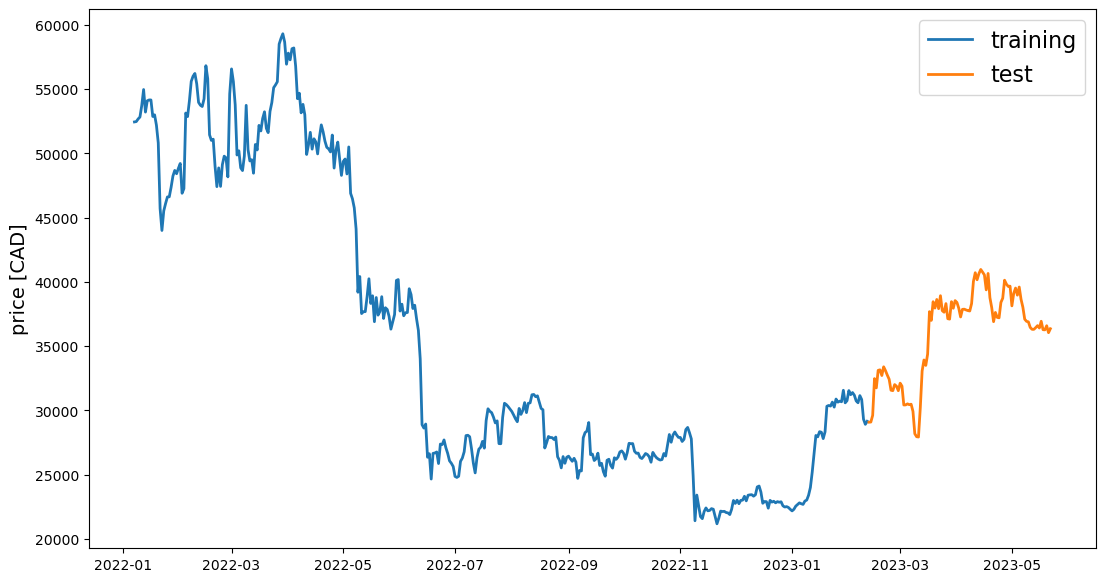

In [7]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [8]:
def normalise_zero_base(df):
    if df.iloc[0].any() != 0:
        return df / df.iloc[0] - 1
    else:
        return df


In [9]:
def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [10]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [11]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [12]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [48]:
def build_lstm_model_MC(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, dropout_mc_samples=10, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    # Dropout Monte Carlo
    model.add(MCdropout(dropout_mc_samples))  # Ajout de la couche de Dropout Monte Carlo

    model.compile(loss=loss, optimizer=optimizer)
    return model


In [13]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [14]:
hist = hist.drop(columns=['conversionType', 'conversionSymbol'])

In [15]:
hist = hist.drop(columns=['volumefrom', 'volumeto'])

In [16]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [17]:
non_numeric_values = pd.to_numeric(hist[target_col], errors='coerce').isna()
print(hist[target_col][non_numeric_values])


Series([], Name: close, dtype: float64)


In [18]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0023
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0021
Epoch 5/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0016
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 8/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 9/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 11/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 12/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 13/20
13/13 [==============================

In [19]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

3/3 [==============================] - 0s 3ms/step


0.019708272386966888

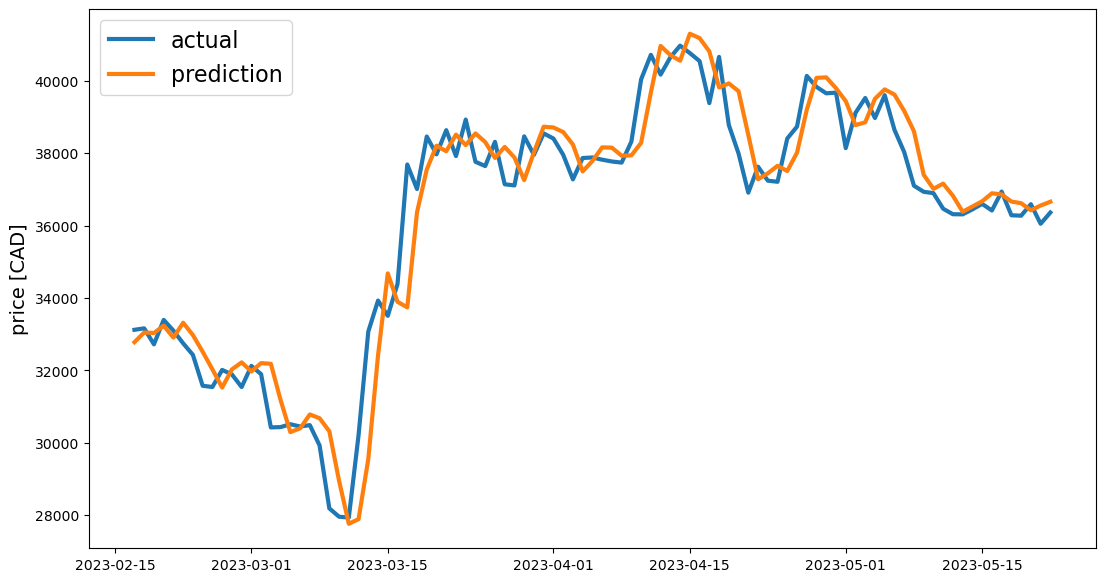

In [20]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [21]:
model.save('first_model.h5')

In [52]:
model_MC = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 2/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 3/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 4/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 6/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 7/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 8/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 9/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0011
Epoch 10/20
13/13 [==============================] - 0s 3ms/step - loss: 0.0011
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 12/20
13/13 [==============================] - 0s 4ms/step - loss: 0.0010
Epoch 13/20
13/13 [==============================

In [40]:
def predict_from_csv(path_to_csv, model_path='first_model.h5'):
    
    df = pd.read_csv(path_to_csv)
    df = df[['date', 'high', 'low', 'open', 'close']]
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index, unit='s')
    target_col = 'close'

    window_len = 5
    zero_base = True

    X = extract_window_data(df, window_len, zero_base)
    y = df[target_col][window_len:].values
    if zero_base:
        y = y / df[target_col][:-window_len].values - 1

    preds = model.predict(X).squeeze()
    
    preds = df[target_col].values[:-window_len] * (preds + 1)
    preds = pd.Series(index=df.index[window_len:], data=preds)

    line_plot(df[target_col][window_len:], preds, 'actual', 'prediction', lw=3)

    return preds


33/33 [==============================] - 0s 1ms/step


date
2021-04-10 03:00:00    225.431159
2021-04-10 04:00:00    228.001400
2021-04-10 05:00:00    231.989930
2021-04-10 06:00:00    234.762058
2021-04-10 07:00:00    234.204447
                          ...    
2021-05-23 15:00:00    137.747844
2021-05-23 16:00:00    138.987415
2021-05-23 17:00:00    131.185511
2021-05-23 18:00:00    130.920621
2021-05-23 19:00:00    130.312363
Length: 1049, dtype: float64

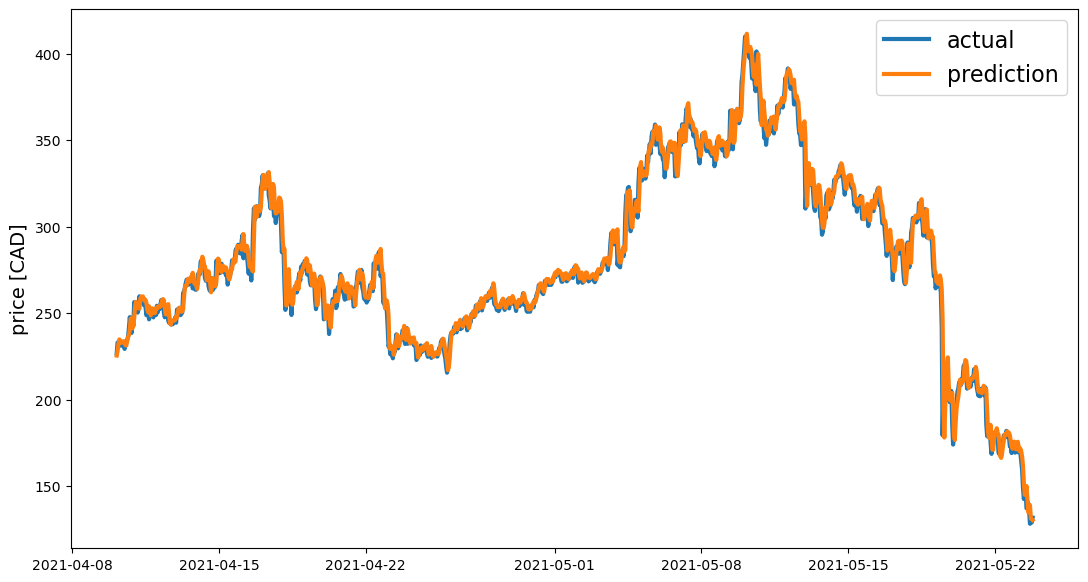

In [44]:
predict_from_csv('../trade_training-datasets/training-set_USDT_BTC-3.csv')

In [49]:
def predict_with_dropout(model, x, n_samples):
    predictions = []
    for _ in range(n_samples):
        predictions.append(model.predict(x))
    return np.array(predictions)

In [53]:
def estimate_risk(predictions):
    risk_estimates = np.std(predictions, axis=0)  # Calcule l'écart-type des prédictions
    return risk_estimates

In [54]:
model_MC.save("model_MC.h5")

In [83]:
def predict_from_csv_MC(csv_file, model, window_len, zero_base, num_mc_samples, alpha=0.05):
    data = pd.read_csv(csv_file)
    data = data.dropna()
    data = data[['high', 'low', 'open', 'volume']]

    live_data = extract_window_data(data, window_len, zero_base)

    predictions = []
    for _ in range(num_mc_samples):
        preds = model.predict(live_data)
        predictions.append(preds)

    predictions = np.array(predictions)
    mean_preds = np.mean(predictions, axis=0)
    std_preds = np.std(predictions, axis=0)

    var_preds = np.percentile(predictions, 100 * alpha, axis=0)

    sorted_preds = np.sort(predictions, axis=0)
    num_cvar = int((1 - alpha) * num_mc_samples)
    cvar_preds = np.mean(sorted_preds[:num_cvar], axis=0)

    risk_levels = np.zeros_like(mean_preds)
    risk_levels[mean_preds <= var_preds] = 1
    risk_levels[(mean_preds > var_preds) & (mean_preds <= cvar_preds)] = 2
    risk_levels[(mean_preds > cvar_preds) & (mean_preds <= mean_preds + std_preds)] = 3
    risk_levels[(mean_preds > mean_preds + std_preds) & (mean_preds <= mean_preds + 2 * std_preds)] = 4
    risk_levels[mean_preds > mean_preds + 2 * std_preds] = 5

    return mean_preds, std_preds, var_preds, cvar_preds, risk_levels

In [84]:
csv_file = "../trade_training-datasets/training-set_USDT_BTC-1.csv"
model = load_model('model_MC.h5')
window_len = 5
zero_base = True
num_mc_samples = 100

mean_preds, std_preds, var_preds, cvar_preds, risk_levels = predict_from_csv_MC(csv_file, model, window_len, zero_base, num_mc_samples)

18/18 [==============================] - 0s 2ms/step


In [87]:
lower_bound = var_preds
upper_bound = cvar_preds

for i, pred in enumerate(mean_preds):
    risk = risk_levels[i]
    print(f"Prediction: {pred}, Risk Level: {int(risk)}")

Prediction: [0.00508824], Risk Level: 2
Prediction: [0.00294011], Risk Level: 3
Prediction: [4.1374005e-05], Risk Level: 1
Prediction: [-0.00418782], Risk Level: 2
Prediction: [-0.00312845], Risk Level: 3
Prediction: [-0.00148776], Risk Level: 1
Prediction: [-4.2278552e-06], Risk Level: 1
Prediction: [0.00041742], Risk Level: 1
Prediction: [0.0018992], Risk Level: 1
Prediction: [0.00107891], Risk Level: 1
Prediction: [-0.0022099], Risk Level: 2
Prediction: [-0.00147349], Risk Level: 1
Prediction: [0.00075818], Risk Level: 3
Prediction: [-0.00074521], Risk Level: 1
Prediction: [0.00129569], Risk Level: 1
Prediction: [-6.126254e-05], Risk Level: 3
Prediction: [0.00056631], Risk Level: 2
Prediction: [-0.00080348], Risk Level: 3
Prediction: [-0.0014861], Risk Level: 3
Prediction: [0.0003335], Risk Level: 1
Prediction: [0.00248904], Risk Level: 3
Prediction: [0.00427892], Risk Level: 3
Prediction: [0.00277564], Risk Level: 1
Prediction: [0.00170337], Risk Level: 1
Prediction: [0.00108856], 